In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing 
from time import time

## 1. Loading Dataset

In [2]:
df = pd.read_csv('../data/df_reco_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553324 entries, 0 to 553323
Data columns (total 22 columns):
uid                  553324 non-null int64
song_id              553324 non-null int64
freq_P_last_1        553324 non-null int64
freq_P_last_3        553324 non-null int64
freq_P_last_7        553324 non-null int64
freq_P_last_14       553324 non-null int64
freq_P_last_30       553324 non-null int64
freq_P_last_44       553324 non-null int64
freq_D_last_1        553324 non-null int64
freq_D_last_3        553324 non-null int64
freq_D_last_7        553324 non-null int64
freq_D_last_14       553324 non-null int64
freq_D_last_30       553324 non-null int64
freq_D_last_44       553324 non-null int64
rec_P                553324 non-null int64
rec_D                553324 non-null int64
rela_freq_last_1     553324 non-null int64
rela_freq_last_3     553324 non-null int64
rela_freq_last_7     553324 non-null int64
rela_freq_last_14    553324 non-null int64
rela_freq_last_30    553324 n

In [3]:
df.head(10)

,uid,song_id,freq_P_last_1,freq_P_last_3,freq_P_last_7,freq_P_last_14,freq_P_last_30,freq_P_last_44,freq_D_last_1,freq_D_last_3,...,freq_D_last_30,freq_D_last_44,rec_P,rec_D,rela_freq_last_1,rela_freq_last_3,rela_freq_last_7,rela_freq_last_14,rela_freq_last_30,rela_freq_last_44
0,6871077,22399766,0,0,0,0,2,2,0,0,...,0,0,18,0,0,0,0,0,0,0
1,9644453,6819013,0,0,0,0,0,1,0,0,...,0,0,40,0,0,0,0,0,0,1
2,12781898,4757745,0,0,0,0,0,1,0,0,...,0,0,43,0,0,0,0,0,0,0
3,12805959,12036103,1,2,8,14,14,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14530206,5275323,0,0,0,0,2,2,0,0,...,0,0,29,0,0,0,0,0,0,0
5,14915165,23537652,0,0,0,0,1,1,0,0,...,0,0,18,0,0,0,0,0,0,0
6,16202430,23110924,0,0,0,0,0,1,0,0,...,0,2,43,43,0,0,0,0,0,0
7,21776440,7180760,0,0,0,0,0,1,0,0,...,0,0,43,0,0,0,0,0,0,0
8,22769152,137975,0,0,0,0,0,1,0,0,...,0,0,43,0,0,0,0,0,0,1
9,31407570,665901,0,0,1,2,3,6,0,0,...,0,0,4,0,0,0,1,2,2,4


## 2. User Cleaning and Implicit Rating Generation

In [4]:
df_user_counts = df['uid'].value_counts()
df_user_counts.head(10)

168611409    1882
168584901    1745
168543021    1323
168909986    1234
168775506    1226
168822524    1104
168664158    1088
168754788    1084
168822909    1076
168721874    1049
Name: uid, dtype: int64

There are many users with **few** records. It is necessary to remove those invincible records.

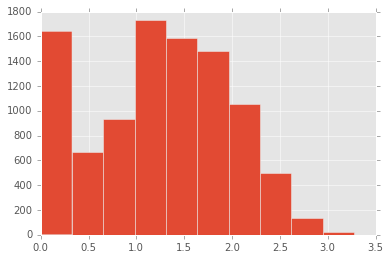

In [5]:
df_user_counts.apply(np.log10).hist()
plt.show()

In [6]:
df_users = df_user_counts[df_user_counts > 5]

In [7]:
# df_song_counts = df['song_id'].value_counts()
# df_song_counts.head(10)
# df_song_counts.apply(np.log10).hist()
# plt.show()
# df_songs = df_song_counts[df_song_counts > 5]

In [8]:

df_tidy = df.set_index('uid').loc[df_users.index].reset_index()
# df_tidy = df.set_index('uid').loc[df_users.index].reset_index()\
#             .set_index('song_id').loc[df_songs.index].reset_index()
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547741 entries, 0 to 547740
Data columns (total 22 columns):
uid                  547741 non-null int64
song_id              547741 non-null int64
freq_P_last_1        547741 non-null int64
freq_P_last_3        547741 non-null int64
freq_P_last_7        547741 non-null int64
freq_P_last_14       547741 non-null int64
freq_P_last_30       547741 non-null int64
freq_P_last_44       547741 non-null int64
freq_D_last_1        547741 non-null int64
freq_D_last_3        547741 non-null int64
freq_D_last_7        547741 non-null int64
freq_D_last_14       547741 non-null int64
freq_D_last_30       547741 non-null int64
freq_D_last_44       547741 non-null int64
rec_P                547741 non-null int64
rec_D                547741 non-null int64
rela_freq_last_1     547741 non-null int64
rela_freq_last_3     547741 non-null int64
rela_freq_last_7     547741 non-null int64
rela_freq_last_14    547741 non-null int64
rela_freq_last_30    547741 n

In [9]:
reco_features = ['freq_P_last_44', 'freq_D_last_44', 'rela_freq_last_44']
df_1 = df_tidy[reco_features]

# filter the data without downloading record
df_1 = df_1.loc[(df.freq_D_last_44!=0) & ((df.freq_P_last_44!=0) | (df.rela_freq_last_44!=0))]

### Outlier Detection
The Data has a long tail. It is reasonable to remove both very small and big values, which are both invincible. 
However, from the descriptive statistic below, the maximum values of the features fall in a normal interval. 

In [10]:
df_1.describe()

,freq_P_last_44,freq_D_last_44,rela_freq_last_44
count,72310.000000,72310.000000,72310.000000
mean,3.404868,0.146536,1.113000
std,11.874277,0.401482,5.244973
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,2.000000,0.000000,1.000000
max,1496.000000,7.000000,1091.000000


In [11]:
df_1 = df_1.apply(lambda x: np.log10(x+1))
df_1.describe()

,freq_P_last_44,freq_D_last_44,rela_freq_last_44
count,72310.000000,72310.000000,72310.000000
mean,0.472922,0.042400,0.191721
std,0.287242,0.109528,0.273981
min,0.301030,0.000000,0.000000
25%,0.301030,0.000000,0.000000
50%,0.301030,0.000000,0.000000
75%,0.477121,0.000000,0.301030
max,3.175222,0.903090,3.038223


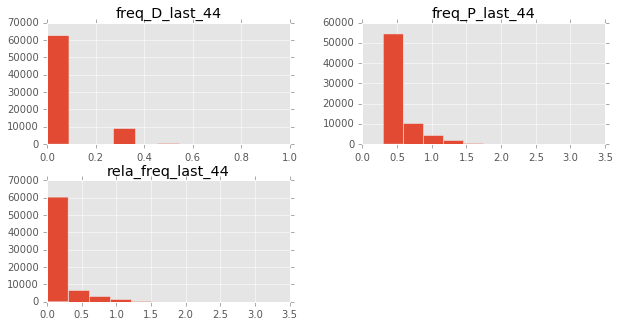

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
df_1.hist()
plt.show()
%matplotlib inline

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
df_1 = pd.DataFrame(min_max_scaler.fit_transform(df_1))

### Utility Matrix

In [14]:
df_utility = df[['uid', 'song_id']].copy()
df_utility[['freq_P_last_44_log10_scale', 
            'freq_D_last_44_log10_scale', 
            'rela_freq_last_44_log10_scale']] = df_1
df_utility['composite_eval'] = 0.2*df_utility['freq_P_last_44_log10_scale'] \
                                + 0.5*df_utility['freq_D_last_44_log10_scale'] \
                                + 0.3*df_utility['rela_freq_last_44_log10_scale']

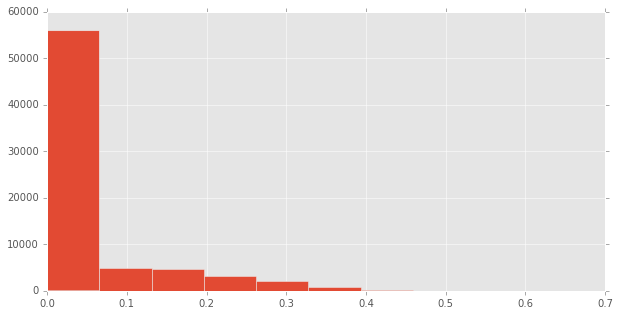

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
df_utility['composite_eval'].hist()
plt.show()
%matplotlib inline

In [16]:
rat_min = np.min(df_utility['composite_eval'])
rat_max = np.max(df_utility['composite_eval'])
# rat_step = (rat_max - rat_min)/5
# rat_bins = np.append(np.arange(rat_min, rat_max, rat_step), rat_max)

rat_step = (rat_max - rat_min)/15
rat_bins = np.array([rat_min, rat_min+rat_step*.5, rat_min+rat_step*1, 
                      rat_min+rat_step*5, rat_min+rat_step*7, rat_max])

In [17]:
df_utility['implicit_rating'] = pd.cut(df_utility['composite_eval'], rat_bins, labels=np.arange(1, 6))
df_utility['implicit_rating'].value_counts()

2    15950
3    14693
1     7088
4     3673
5     1795
dtype: int64

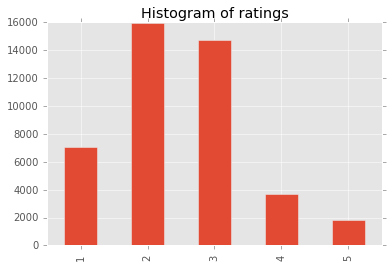

In [18]:
df_utility['implicit_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Histogram of ratings')
plt.show()

In [19]:
df_ratings = df_utility[['uid', 'song_id', 'implicit_rating']]
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553324 entries, 0 to 553323
Data columns (total 3 columns):
uid                553324 non-null int64
song_id            553324 non-null int64
implicit_rating    43199 non-null category
dtypes: category(1), int64(2)
memory usage: 9.0 MB


In [20]:
df_ratings = df_ratings[df_ratings['implicit_rating'].notnull()]
df_ratings['implicit_rating'] = df_ratings['implicit_rating'].astype('int')
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43199 entries, 0 to 72309
Data columns (total 3 columns):
uid                43199 non-null int64
song_id            43199 non-null int64
implicit_rating    43199 non-null int64
dtypes: int64(3)
memory usage: 1.3 MB


## 3. Item-Item Recommender (GraphLab)

In [21]:
import graphlab

In [22]:
sf_ratings = graphlab.SFrame(df_ratings)
sf_ratings # SFrame similar to DataFrame

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1531075412.log


This non-commercial license of GraphLab Create for academic use is assigned to pli3@tulane.edu and will expire on May 22, 2019.


uid,song_id,implicit_rating
6871077,22399766,3
9644453,6819013,3
12781898,4757745,2
12805959,12036103,1
14530206,5275323,2
14915165,23537652,3
16202430,23110924,3
21776440,7180760,3
22769152,137975,2
31407570,665901,3


In [23]:
# item-item recommender
item_item_rec = graphlab.recommender.item_similarity_recommender.create(sf_ratings,
                                                                        user_id='uid',
                                                                        item_id='song_id',
                                                                        target = 'implicit_rating')

Recsys training: model = item_similarity

Preparing data set.

Data has 43199 observations with 6536 users and 24239 items.

Data prepared in: 0.069568s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.37ms                         | 15.25      |

| 3.326ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.49s                               | 0                | 4               |

| 4.16s                               | 100              | 24239           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 5.19455s

In [24]:
# For every user, recommend top 3 songs
item_item_rec_result = item_item_rec.recommend(k=5, verbose=False)
item_item_rec_result

uid,song_id,score,rank
6871077,6435758,0.0384615384615,1
6871077,58118,0.0384615384615,2
6871077,9561562,0.0384615384615,3
6871077,6451058,0.0384615384615,4
6871077,4756523,0.0384615384615,5
9644453,6206361,0.025,1
9644453,3418566,0.025,2
9644453,20110102,0.025,3
9644453,363294,0.025,4
9644453,6300485,0.025,5


In [25]:
# For a specific user, 
item_item_rec_result_spe = item_item_rec.recommend(users=[sf_ratings['uid'][0]], k=5, verbose=False)
item_item_rec_result_spe

uid,song_id,score,rank
6871077,6435758,0.0384615384615,1
6871077,58118,0.0384615384615,2
6871077,9561562,0.0384615384615,3
6871077,6451058,0.0384615384615,4
6871077,4756523,0.0384615384615,5


## 4. Popularity-Based Recommender

In [26]:
# build recommendation system
pop_rec = graphlab.popularity_recommender.create(sf_ratings, 
                                                 user_id = 'uid', 
                                                 item_id = 'song_id',
                                                 target = 'implicit_rating')

Recsys training: model = popularity

Preparing data set.

Data has 43199 observations with 6536 users and 24239 items.

Data prepared in: 0.097465s

43199 observations to process; with 24239 unique items.

In [27]:
# get recommendation
pop_result = pop_rec.recommend()

recommendations finished on 1000/6536 queries. users per second: 17592.3

recommendations finished on 2000/6536 queries. users per second: 17192

recommendations finished on 3000/6536 queries. users per second: 19087.7

recommendations finished on 4000/6536 queries. users per second: 19039.8

recommendations finished on 5000/6536 queries. users per second: 19190.3

recommendations finished on 6000/6536 queries. users per second: 18728.4

As we can see, in the popularity based model, the recommendations for every user are the same. 

In [28]:
pop_result.print_rows(num_rows=30)

+----------+----------+-------+------+
|   uid    | song_id  | score | rank |
+----------+----------+-------+------+
| 6871077  | 4391923  |  5.0  |  1   |
| 6871077  | 7097037  |  5.0  |  2   |
| 6871077  | 6729063  |  5.0  |  3   |
| 6871077  | 6054540  |  5.0  |  4   |
| 6871077  | 3219291  |  5.0  |  5   |
| 6871077  | 20870140 |  5.0  |  6   |
| 6871077  | 3591502  |  5.0  |  7   |
| 6871077  | 3296328  |  5.0  |  8   |
| 6871077  |  353224  |  5.0  |  9   |
| 6871077  |  981660  |  5.0  |  10  |
| 9644453  | 4391923  |  5.0  |  1   |
| 9644453  | 7097037  |  5.0  |  2   |
| 9644453  | 6729063  |  5.0  |  3   |
| 9644453  | 6054540  |  5.0  |  4   |
| 9644453  | 3219291  |  5.0  |  5   |
| 9644453  | 20870140 |  5.0  |  6   |
| 9644453  | 3591502  |  5.0  |  7   |
| 9644453  | 3296328  |  5.0  |  8   |
| 9644453  |  353224  |  5.0  |  9   |
| 9644453  |  981660  |  5.0  |  10  |
| 12781898 | 4391923  |  5.0  |  1   |
| 12781898 | 7097037  |  5.0  |  2   |
| 12781898 | 6729063  |  

In [29]:
pop_rec.recommend(users = sf_ratings['uid'][ :2], k=5)

uid,song_id,score,rank
6871077,20870140,5.0,1
6871077,3591502,5.0,2
6871077,3296328,5.0,3
6871077,353224,5.0,4
6871077,981660,5.0,5
9644453,20870140,5.0,1
9644453,3591502,5.0,2
9644453,3296328,5.0,3
9644453,353224,5.0,4
9644453,981660,5.0,5


## 5. Matrix Factorization Recommender 

In [30]:
# build the MF model
rec = graphlab.recommender.factorization_recommender.create(
            sf_ratings,
            user_id='uid',
            item_id='song_id',
            target='implicit_rating',
            solver='als',
            side_data_factorization=False)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 43199 observations with 6536 users and 24239 items.

Data prepared in: 0.074193s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 73us         | NA                     |

+---------+--------------+------------------------+

| 0       | 50.967ms     | 0.235844               |

| 1       | 121.85ms     | 0.0790017              |

| 2       | 175.396ms    | 0.0545694              |

| 3       | 236.922ms    | 0.0426304              |

| 4       | 286.405ms    | 0.035278               |

| 5       | 360.358ms    | 0.0299735              |

| 6       | 409.62ms     | 0.0259233              |

| 7       | 450.208ms    | 0.022702               |

| 8       | 513.77ms     | 0.0201221              |

| 9       | 576.191ms    | 0.0180504              |

| 10      | 625.311ms    | 0.0163554              |

| 11      | 698.002ms    | 0.014947               |

| 12      | 743.366ms    | 0.0137617              |

| 13      | 805.789ms    | 0.0127494              |

| 14      | 844.368ms    | 0.0118759              |

| 15      | 906.184ms    | 0.0111164              |

| 16      | 962.76ms     | 0.0104495              |

| 17      | 999.525ms    | 0.0098592              |

| 18      | 1.05s        | 0.00933046             |

| 19      | 1.10s        | 0.00885336             |

| 20      | 1.15s        | 0.00841947             |

| 21      | 1.21s        | 0.00801883             |

| 22      | 1.27s        | 0.00764756             |

| 23      | 1.33s        | 0.00729914             |

| 24      | 1.40s        | 0.00696891             |

| 25      | 1.44s        | 0.00665437             |

| 26      | 1.51s        | 0.00635279             |

| 27      | 1.57s        | 0.00606355             |

| 28      | 1.62s        | 0.00578591             |

| 29      | 1.70s        | 0.00551978             |

| 30      | 1.74s        | 0.00526571             |

| 31      | 1.80s        | 0.00502372             |

| 32      | 1.85s        | 0.00479277             |

| 33      | 1.90s        | 0.00457458             |

| 34      | 1.98s        | 0.00437026             |

| 35      | 2.03s        | 0.0041791              |

| 36      | 2.09s        | 0.00399853             |

| 37      | 2.13s        | 0.00383146             |

| 38      | 2.19s        | 0.00367551             |

| 39      | 2.25s        | 0.0035313              |

| 40      | 2.30s        | 0.003396               |

| 41      | 2.38s        | 0.00327129             |

| 42      | 2.43s        | 0.00315418             |

| 43      | 2.47s        | 0.00304526             |

| 44      | 2.57s        | 0.00294318             |

| 45      | 2.64s        | 0.00284732             |

| 46      | 2.76s        | 0.00275667             |

| 47      | 2.83s        | 0.00267227             |

| 48      | 2.88s        | 0.00259229             |

| 49      | 2.96s        | 0.00251598             |

| FINAL   | 2.96s        | 0.00251598             |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

###  See the prediction rating for a user on a song 

In [31]:
one_datapoint_sf = graphlab.SFrame({'uid': [sf_ratings['uid'][0]], 'song_id': [sf_ratings['song_id'][10]]}) 
one_datapoint_sf

song_id,uid
2268517,6871077


In [32]:
print "rating for datapoint\n", one_datapoint_sf, "\n:", rec.predict(one_datapoint_sf)[0] 

rating for datapoint
+---------+---------+
| song_id |   uid   |
+---------+---------+
| 2268517 | 6871077 |
+---------+---------+
[1 rows x 2 columns]
 
: 2.3839258274


In [33]:
# For a specic user
rec.recommend(users=[sf_ratings['uid'][0]], k=5)

uid,song_id,score,rank
6871077,405670,40.3687275594,1
6871077,23485496,33.3061131185,2
6871077,9952428,17.6620873159,3
6871077,9102791,16.8748463338,4
6871077,6288512,14.7377642339,5


### Training Root Mean Squared Error

In [34]:
print "The training rmse:", rec['training_rmse']

The training rmse: 0.00251598315907


### Regularization Method for MF Recommender 

In [35]:
random_seed = 0
regularization_param = 10
rec_regularized = graphlab.recommender.factorization_recommender.create(
                    sf_ratings,
                    user_id='uid',
                    item_id='song_id',
                    target='implicit_rating',
                    solver='als',
                    side_data_factorization=False,
                    regularization=regularization_param,
                    random_seed=random_seed,
                    verbose=False) 
print "training rmse with regularization %s:"%regularization_param, rec_regularized['training_rmse']

Recsys training: model = factorization_recommender

training rmse with regularization 10: 0.998329523228


## Model Tune via Cross-validation
<font color = red>
However, as we can see, the training rmse above is very small, it is very likely for them to suffer a serious over-fitting problem.

In [36]:
kfolds = graphlab.cross_validation.KFold(sf_ratings, 5)
params = dict(user_id='uid', 
              item_id='song_id', 
              target='implicit_rating',
              solver='als', 
              side_data_factorization=False)
paramsearch = graphlab.model_parameter_search.create(
                    kfolds,
                    graphlab.recommender.factorization_recommender.create,
                    params)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Jul-08-2018-13-43-4600000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Jul-08-2018-13-43-4600000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Jul-08-2018-13-43-4600000' already exists. Renaming the job to 'Model-Parameter-Search-Jul-08-2018-13-43-4600000-30600'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Jul-08-2018-13-43-4600000-30600' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Jul-08-2018-13-43-4600000-30600' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Jul-08-2018-13-43-4600001' ready for execution


In [37]:
best_params = paramsearch.get_best_params('mean_validation_rmse', ascending=True)
best_params

{'item_id': 'song_id',
 'linear_regularization': 1e-09,
 'max_iterations': 50,
 'num_factors': 32,
 'regularization': 0.0001,
 'side_data_factorization': False,
 'solver': 'als',
 'target': 'implicit_rating',
 'user_id': 'uid'}

In [38]:
results_df = paramsearch.get_results().to_dataframe()
results_df_sorted = results_df.sort_values('mean_validation_rmse')
print 'The params of the best model are: \n', best_params, \
       '\n The mean training rmse is: \n %s'%results_df_sorted['mean_training_rmse'].iloc[0], \
       '\n The mean validation rmse is: \n %s'%results_df_sorted['mean_validation_rmse'].iloc[0]

The params of the best model are: 
{'side_data_factorization': False, 'regularization': 0.0001, 'user_id': 'uid', 'target': 'implicit_rating', 'solver': 'als', 'num_factors': 32, 'item_id': 'song_id', 'max_iterations': 50, 'linear_regularization': 1e-09} 
 The mean training rmse is: 
 0.762248670377 
 The mean validation rmse is: 
 1.00255490695


After tuning the model we finally acquire is fairly robust. 